In [1]:
from torchvision.models import mobilenet_v3_large
import torch
from functools import partial
from torch import nn
from monarch_cuda import conv2d_forward, conv2d_backward
from timeit import timeit, repeat

x = torch.randn([1, 3, 224, 224])
model = mobilenet_v3_large()

def hook(module, args, output, problem_sizes):
    p_size = args[0].shape + (module.kernel_size)
    print("Add problem size:", p_size)
    problem_sizes += [p_size]

problem_sizes = []

for mod in model.modules():
    if isinstance(mod, torch.nn.Conv2d) and mod.groups == mod.in_channels:
        mod.register_forward_hook(partial(hook, problem_sizes=problem_sizes))

model(x);

Add problem size: torch.Size([1, 16, 112, 112, 3, 3])
Add problem size: torch.Size([1, 64, 112, 112, 3, 3])
Add problem size: torch.Size([1, 72, 56, 56, 3, 3])
Add problem size: torch.Size([1, 72, 56, 56, 5, 5])
Add problem size: torch.Size([1, 120, 28, 28, 5, 5])
Add problem size: torch.Size([1, 120, 28, 28, 5, 5])
Add problem size: torch.Size([1, 240, 28, 28, 3, 3])
Add problem size: torch.Size([1, 200, 14, 14, 3, 3])
Add problem size: torch.Size([1, 184, 14, 14, 3, 3])
Add problem size: torch.Size([1, 184, 14, 14, 3, 3])
Add problem size: torch.Size([1, 480, 14, 14, 3, 3])
Add problem size: torch.Size([1, 672, 14, 14, 3, 3])
Add problem size: torch.Size([1, 672, 14, 14, 5, 5])
Add problem size: torch.Size([1, 960, 7, 7, 5, 5])
Add problem size: torch.Size([1, 960, 7, 7, 5, 5])


In [2]:
for p_size in problem_sizes:
    _, num_channels, h, w, kernel_size, _ = p_size
    n = 32

    input = torch.ceil(
        torch.empty(size=(n, num_channels, h, w), dtype=torch.float, device="cuda").uniform_(-4.5, 3.5)
    )
    weight = torch.ceil(
        torch.empty(size=(num_channels, 1, kernel_size, kernel_size), dtype=torch.float, device="cuda").uniform_(-4.5, 3.5)
    )
    grad_output = torch.ceil(
        torch.empty(size=(n, num_channels, h, w), dtype=torch.float, device="cuda").uniform_(-4.5, 3.5)
    )

    output_torch = torch.ops.aten.conv2d(input, weight, stride=(1,1), padding=(kernel_size // 2, kernel_size // 2), groups=num_channels)
    output_custom = conv2d_forward(input, weight.contiguous(), kernel_size // 2)
    assert torch.allclose(output_torch, output_custom)

    grad_input_torch = torch.nn.grad.conv2d_input(
        (n, num_channels, h, w),
        weight, grad_output,
        stride=(1,1), padding=(kernel_size // 2, kernel_size // 2), groups=num_channels
    )
    grad_weight_torch = torch.nn.grad.conv2d_weight(
        input, (num_channels, 1, kernel_size, kernel_size), grad_output,
        stride=(1,1), padding=(kernel_size // 2, kernel_size // 2), groups=num_channels
    )

    grad_input_custom, grad_weight_custom = conv2d_backward(grad_output, input, weight, kernel_size // 2)
    assert torch.allclose(grad_input_torch, grad_input_custom)
    assert torch.allclose(grad_weight_torch, grad_weight_custom)

In [3]:
class Conv2dFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, inputs, weights, padding):
        h_pad, w_pad = padding
        outputs = conv2d_forward(inputs, weights, h_pad)
        ctx.padding = padding
        ctx.save_for_backward(inputs, weights)
        return outputs
    
    @staticmethod
    def backward(ctx, dout):
        inputs, weights = ctx.saved_tensors
        dout = dout.contiguous()
        assert inputs.is_contiguous() and weights.is_contiguous()

        h_pad, w_pad = ctx.padding
        din, dweights = conv2d_backward(dout, inputs, weights, h_pad)

        return din, dweights, None


class CustomDepthwiseConv2d(nn.Conv2d):
    def forward(self, x):
        return Conv2dFunc.apply(x, self.weight, self.padding)
    
def run_bwd(layer, x):
    layer.weight.grad = None
    x.grad = None
    y = layer(x)
    y.mean().backward()
    torch.cuda.synchronize()
    return y

@torch.no_grad()
def run_fwd(layer, x):
    y = layer(x)
    torch.cuda.synchronize()
    return y

def test(p_size, n=32, atol=1e-7):
    _, num_channels, h, w, kernel_size, _ = p_size

    custom_layer = CustomDepthwiseConv2d(
        num_channels,
        num_channels,
        kernel_size=kernel_size,
        padding=kernel_size // 2,
        groups=num_channels,
        bias=False,
    ).cuda()

    torch_layer = nn.Conv2d(
        num_channels,
        num_channels,
        kernel_size=kernel_size,
        padding=kernel_size // 2,
        groups=num_channels,
        bias=False,
    ).cuda()
    torch_layer.load_state_dict(custom_layer.state_dict())

    tmp = dict()
    def hook(mod, grad_in, grad_out):
        tmp["grad_out"] = grad_out

    torch_layer.register_backward_hook(hook)

    x1 = torch.randn([n, num_channels, h, w]).cuda()
    x2 = x1.clone()

    x1.requires_grad_(True)
    x2.requires_grad_(True)

    # Exectue
    y1 = custom_layer(x1)
    y2 = torch_layer(x2)
    y1.exp().mean().backward()
    y2.exp().mean().backward()

    max_error_y = (y1 - y2).abs().max()
    assert torch.allclose(y1, y2, atol=atol)

    max_error_din = (x1.grad - x2.grad).abs().max()
    assert torch.allclose(x1.grad, x2.grad, atol=atol)

    max_error_dw = (custom_layer.weight.grad - torch_layer.weight.grad).abs().max()
    assert torch.allclose(custom_layer.weight.grad, torch_layer.weight.grad, atol=atol)

    print(f"P: {p_size}, max_error_y={max_error_y}, max_error_din={max_error_din}, max_error_dw={max_error_dw}")

    return custom_layer, torch_layer, x1, x2, tmp["grad_out"]

In [4]:
for p_size in problem_sizes:
    kernel_size = p_size[-1]
    custom_layer, torch_layer, x1, x2, _ = test(p_size, n=64, atol=1e-7)

/home/vinnamkim/flash-fft-conv/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


P: torch.Size([1, 16, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=2.2737367544323206e-13, max_error_dw=3.725290298461914e-09
P: torch.Size([1, 64, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=4.263256414560601e-14, max_error_dw=9.313225746154785e-10
P: torch.Size([1, 72, 56, 56, 3, 3]), max_error_y=0.0, max_error_din=1.1368683772161603e-13, max_error_dw=9.313225746154785e-10
P: torch.Size([1, 72, 56, 56, 5, 5]), max_error_y=0.0, max_error_din=1.1368683772161603e-13, max_error_dw=4.656612873077393e-10
P: torch.Size([1, 120, 28, 28, 5, 5]), max_error_y=0.0, max_error_din=3.410605131648481e-13, max_error_dw=2.3283064365386963e-10
P: torch.Size([1, 120, 28, 28, 5, 5]), max_error_y=0.0, max_error_din=3.410605131648481e-13, max_error_dw=2.3283064365386963e-10
P: torch.Size([1, 240, 28, 28, 3, 3]), max_error_y=0.0, max_error_din=2.2737367544323206e-13, max_error_dw=2.3283064365386963e-10
P: torch.Size([1, 200, 14, 14, 3, 3]), max_error_y=0.0, max_error_din=6.821210263296962e-13, max_

In [5]:
fwd_results = []

for p_size in problem_sizes:
    _, num_channels, h, w, kernel_size, _ = p_size
    custom_layer, torch_layer, x1, x2, _ = test(p_size, n=64, atol=1e-7)
    
    t1 = %timeit -o -n 1000 run_fwd(custom_layer, x1)
    t2 = %timeit -o -n 1000 run_fwd(torch_layer, x2)

    fwd_results += [("custom", t1.average, t1.stdev, (64, num_channels, h, w, kernel_size))]
    fwd_results += [("torch", t2.average, t2.stdev, (64, num_channels, h, w, kernel_size))]

P: torch.Size([1, 16, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=1.1368683772161603e-13, max_error_dw=3.725290298461914e-09
444 µs ± 4.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
526 µs ± 9.14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 64, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=5.684341886080802e-14, max_error_dw=9.313225746154785e-10
1.71 ms ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.94 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 72, 56, 56, 3, 3]), max_error_y=0.0, max_error_din=1.1368683772161603e-13, max_error_dw=9.313225746154785e-10
505 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
574 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 72, 56, 56, 5, 5]), max_error_y=0.0, max_error_din=1.4210854715202004e-13, max_error_dw=4.656612873077393e-10
509 µs ± 3.56 µs per loop (mean ± std. dev. of

In [6]:
bwd_results = []

for p_size in problem_sizes:
    _, num_channels, h, w, kernel_size, _ = p_size
    custom_layer, torch_layer, x1, x2, _ = test(p_size, n=64, atol=1e-7)

    t1 = %timeit -o -n 1000 run_bwd(custom_layer, x1)
    t2 = %timeit -o -n 1000 run_bwd(torch_layer, x2)

    bwd_results += [("custom", t1.average, t1.stdev, (64, num_channels, h, w, kernel_size))]
    bwd_results += [("torch", t2.average, t2.stdev, (64, num_channels, h, w, kernel_size))]

P: torch.Size([1, 16, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=1.7053025658242404e-13, max_error_dw=3.725290298461914e-09
2.01 ms ± 3.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.05 ms ± 3.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 64, 112, 112, 3, 3]), max_error_y=0.0, max_error_din=5.684341886080802e-14, max_error_dw=9.313225746154785e-10
7.87 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
7.76 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 72, 56, 56, 3, 3]), max_error_y=0.0, max_error_din=1.7053025658242404e-13, max_error_dw=9.313225746154785e-10
2.44 ms ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.28 ms ± 3.51 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
P: torch.Size([1, 72, 56, 56, 5, 5]), max_error_y=0.0, max_error_din=1.1368683772161603e-13, max_error_dw=4.656612873077393e-10
4.15 ms ± 4.02 µs per loop (mean ± std. d

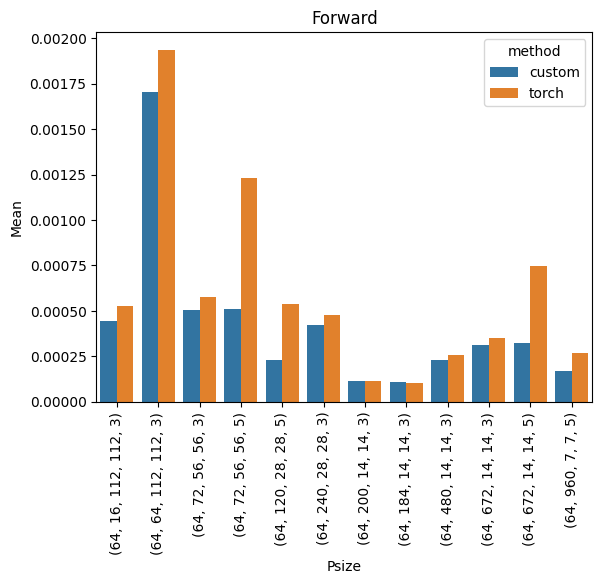

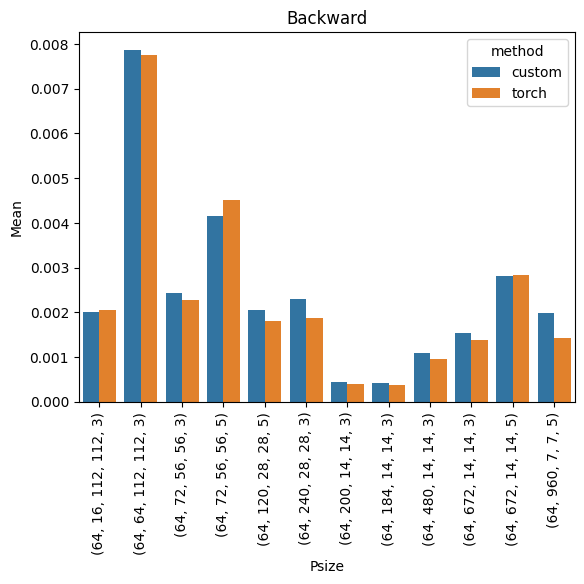

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot(results, title):
    df = pd.DataFrame(results, columns=["method", "mean", "std", "psize"])

    df['psize'] = df['psize'].astype(str)
    sns.barplot(x='psize', y='mean', hue='method', errorbar=None, data=df)

    plt.xticks(rotation=90)

    plt.title(title)
    plt.xlabel('Psize')
    plt.ylabel('Mean')

    plt.show()

plot(fwd_results, "Forward")
plot(bwd_results, "Backward")

In [5]:
model = nn.Sequential(
    nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),
    nn.Conv2d(32, 64, kernel_size=1, bias=False)
).cuda()

x = torch.randn([1, 32, 64, 64], requires_grad=False).cuda()

In [6]:
model[0].weight.shape

torch.Size([32, 1, 3, 3])

In [7]:
model[1].weight.shape

torch.Size([64, 32, 1, 1])

In [8]:
for param in model.parameters():
    if param.grad is not None:
        param.grad.data.fill_(0.0)

y = model(x)
y.mean().backward()

/home/vinnamkim/flash-fft-conv/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [1]:
import torch
from torch import nn
from monarch_cuda import conv2d_forward, conv2d_backward

n, num_channels, h, w = 32, 16, 112, 112
#n, num_channels, h, w = 16, 960, 7, 7
n, num_channels, h, w = 32, 240, 28, 28
# n = 4
# num_channels = 512
# h = w = 64

depthwise_conv2d = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, groups=num_channels, bias=False).cuda()
x = torch.randn([n, num_channels, h, w], requires_grad=False).cuda()

@torch.no_grad()
def run():
    y = depthwise_conv2d(x)
    torch.cuda.synchronize()
    return y

y = run()

@torch.no_grad()
def run_my():
    y = conv2d_forward(x, depthwise_conv2d.weight.contiguous(), 1)
    torch.cuda.synchronize()
    return y

z = run_my()

print(torch.allclose(y, z))

True


In [30]:
%timeit -n 1000 run_my()

1.17 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
%timeit -n 1000 run()

1.72 ms ± 8.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [1]:
import torch
from torch import nn
from monarch_cuda import conv2d_backward

torch.manual_seed(3003)

# n, num_channels, h, w = 32, 16, 112, 112
#n, num_channels, h, w = 16, 960, 7, 7
# n, num_channels, h, w = 32, 240, 28, 28
n, num_channels, h, w = 1, 2, 3, 3
# n = 4
# num_channels = 512
# h = w = 64

depthwise_conv2d = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, groups=num_channels, bias=False).cuda()
x = torch.randn([n, num_channels, h, w], requires_grad=True).cuda()

states = {}
def log_bwd(module, grad_input, grad_output):
    states["grad_input"] = grad_input
    states["grad_output"] = grad_output

depthwise_conv2d.register_full_backward_hook(log_bwd)

y = depthwise_conv2d(x)
y.exp().sum().backward()

print(states)

{'grad_input': (tensor([[[[-0.2183,  0.2789,  0.0979],
          [-0.1423, -0.4692, -0.1749],
          [-0.1839, -0.2082, -0.1159]],

         [[-0.7890, -1.3427, -0.4157],
          [ 0.0278, -1.2945, -0.7607],
          [-0.1968, -0.4257, -0.1693]]]], device='cuda:0'),), 'grad_output': (tensor([[[[0.9344, 1.0868, 0.6731],
          [0.8925, 0.6576, 1.3336],
          [1.1533, 0.8259, 0.7464]],

         [[2.2257, 0.8318, 0.8736],
          [0.9656, 1.8273, 1.8586],
          [0.7153, 0.4761, 1.3053]]]], device='cuda:0'),)}


In [2]:
with torch.no_grad():
    din, dweights = conv2d_backward(states["grad_output"][0], x.clone(), depthwise_conv2d.weight, 1)
# print(din)
# print(states)
# print(din.shape)
print(dweights)
print(depthwise_conv2d.weight.grad.data)
# print(dweights.shape)
print(torch.allclose(states["grad_input"][0], din))
print(torch.allclose(depthwise_conv2d.weight.grad.data, dweights))

tensor([[[[ 2.4781,  2.4529,  1.5677],
          [ 3.4162,  5.0975,  2.0699],
          [ 3.4967,  3.3039,  1.2509]]],


        [[[-4.0330, -2.7529, -1.1068],
          [-0.8394, -3.9504, -2.7955],
          [-1.0433,  4.1894,  0.8581]]]], device='cuda:0')
tensor([[[[ 2.4781,  2.4529,  1.5677],
          [ 3.4162,  5.0975,  2.0699],
          [ 3.4967,  3.3039,  1.2509]]],


        [[[-4.0330, -2.7529, -1.1068],
          [-0.8394, -3.9504, -2.7955],
          [-1.0433,  4.1894,  0.8581]]]], device='cuda:0')
True
True


In [3]:
print(depthwise_conv2d.weight.grad)

tensor([[[[-2.6256, 12.1385, -4.9606],
          [ 0.3313,  0.0327, -4.5083],
          [ 2.0863,  2.7183, 11.1900]]],


        [[[-0.1741,  7.9010, -0.5848],
          [ 1.1680,  9.1308, -1.7229],
          [ 1.8568,  3.9883, -6.0307]]]], device='cuda:0')


In [2]:
states["grad_output"][0]

tensor([[[[1.3339, 0.6068, 1.4437, 0.4591, 3.2536],
          [0.4609, 0.8319, 1.2438, 1.3593, 0.4581],
          [3.2788, 1.1048, 1.0025, 0.9150, 0.8091],
          [0.5265, 2.7995, 1.8639, 1.1154, 1.9408],
          [1.0752, 0.4621, 0.7071, 0.9627, 0.6054]],

         [[0.9014, 2.2644, 1.0638, 0.7618, 1.0463],
          [0.4676, 3.2272, 1.1820, 0.8296, 3.7058],
          [0.9902, 1.6993, 0.2760, 1.1363, 3.5201],
          [0.7246, 0.8807, 0.8306, 1.5082, 1.4903],
          [0.9297, 2.2455, 1.0649, 0.8699, 1.2829]]]], device='cuda:0')

In [3]:
states["grad_input"]

(tensor([[[[-0.3243,  0.2552,  0.0164,  0.2652, -0.7573],
           [ 0.9317,  0.1859,  0.2556,  0.3482,  1.0515],
           [-0.5501,  1.2759,  0.7390,  0.3441,  0.0424],
           [ 0.8952, -1.3240,  0.2384,  0.2251, -0.2865],
           [ 0.2867,  0.9382, -0.4277, -0.1551,  0.1596]],
 
          [[ 0.7385, -0.4478, -0.8459, -0.0750, -0.9847],
           [ 1.1138, -0.2448, -0.7152,  0.7494, -0.9785],
           [ 1.1503, -0.8641, -0.2171,  1.4930, -1.4552],
           [ 0.3670, -0.7512,  0.2272,  0.7006, -1.5908],
           [ 0.7140,  0.2325, -0.1341,  0.1210, -0.4547]]]], device='cuda:0'),)